# **🔍 Finding Similar Respondents & Clustering Survey Data**
### **Understanding Similarity Between Respondents**
This notebook follows a simplified approach to **analyzing survey respondents** based on their **composite scores**. Instead of visualizing a large and complex network, which was the original idea, this focuses on **two streamlined tools**:

### **1️⃣ Explore Similar & Different Respondents**
- Enter a **Respondent ID** to compare an individual against others.
- The system returns **Top 10 Most Similar** and **Top 10 Most Different** respondents.
- This allows for **focused analysis** on who shares similar or different characteristics.

### **2️⃣ Use K-Means Clustering to Identify and Explore Clusters in Respondents**
- Using **machine learning clustering**, respondents are **grouped based on their composite scores**.
- The result is an **interactive visualization** of respondent clusters.
- This approach reveals **patterns in the data** without requiring a massive network.

---
### **📂 Data Used**
- **CSV2.csv** → The cleaned, re-scaled dataset with normalized composite scores.
- The dataset includes **demographics, election choices, crisis impact scores, and personality measures**.


In [50]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Load dataset
file_path = "CSV2.csv"
df = pd.read_csv(file_path, index_col="Respondent ID")

# 🔢 Select the relevant composite scores for comparison
composite_scores = [
    "Systems Thinking Score 0-1", "Trust Score 0-1", "Conspiracy 0-1", "Complexity 0-1",
    "Openness 0-1", "Conscientiousness 0-1", "Extraversion 0-1", "Agreeableness 0-1", "Neuroticism 0-1",
    "Composite Crisis Score (Sum of all Crisis Scores)"
]

# ✅ Compute similarity matrix once for all respondents
similarity_matrix = pd.DataFrame(
    cosine_similarity(df[composite_scores]),
    index=df.index,
    columns=df.index
)

print("✅ Data Loaded & Similarity Computed!")


✅ Data Loaded & Similarity Computed!


In [51]:
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity

# 📂 Load dataset
file_path = "CSV2.csv"
df = pd.read_csv(file_path, index_col="Respondent ID")

# 🔢 Define all available composite scores
composite_scores = [
    "Systems Thinking Score 0-1", "Trust Score 0-1", "Conspiracy 0-1", "Complexity 0-1",
    "Openness 0-1", "Conscientiousness 0-1", "Extraversion 0-1", "Agreeableness 0-1", "Neuroticism 0-1",
    "Composite Crisis Score (Sum of all Crisis Scores)"
]

# Additional Demographic Columns
demographics = ["Age", "Gender", "Last Election: Didn't Vote 0, Democrat 1, Republican 2"]

print("✅ Data Loaded! Select a respondent and scores to compare.")

# 🎛 Input for respondent ID
respondent_id_input = widgets.IntText(
    value=df.index[0],  # Default to first respondent
    description="Respondent ID:"
)

# 🎲 Button to randomly choose a respondent
random_button = widgets.Button(
    description="Choose for Me",
    button_style="info",
    icon="shuffle"
)

# 🎛 Checkboxes for selecting composite scores
score_checkboxes = {score: widgets.Checkbox(value=False, description=score) for score in composite_scores}

# ▶️ Button to find similar respondents
find_button = widgets.Button(
    description="Find Matches",
    button_style="primary",
    icon="search"
)

# 📌 Function to get selected composite scores
def get_selected_scores():
    return [key for key, checkbox in score_checkboxes.items() if checkbox.value]

# 🎲 Function to randomly select a respondent ID
def choose_random_id(change=None):
    random_id = np.random.choice(df.index)
    respondent_id_input.value = random_id  # Set it in the input box

# 📌 Function to compute similarity based on selected features
def find_similar_different(change=None):
    clear_output(wait=True)
    display(respondent_id_input, random_button, widgets.VBox(list(score_checkboxes.values())), find_button)

    respondent_id = respondent_id_input.value
    selected_scores = get_selected_scores()

    if respondent_id not in df.index:
        print("❌ Respondent ID not found. Please enter a valid ID.")
        return

    if not selected_scores:
        print("⚠️ Please select at least one composite score.")
        return

    # Compute similarity dynamically based on selected scores
    similarity_matrix = pd.DataFrame(
        cosine_similarity(df[selected_scores]),
        index=df.index,
        columns=df.index
    )

    # Retrieve similarity values
    similarities = similarity_matrix.loc[respondent_id].drop(respondent_id)  # Remove self
    most_similar = similarities.nlargest(10)
    most_different = similarities.nsmallest(10)

    print(f"🔍 **Most Similar Respondents to {respondent_id} (Based on {len(selected_scores)} selected scores):**")
    display(format_comparison_table(respondent_id, most_similar.index, similarities, selected_scores))

    print(f"\n🔍 **Most Different Respondents from {respondent_id} (Based on {len(selected_scores)} selected scores):**")
    display(format_comparison_table(respondent_id, most_different.index, similarities, selected_scores))

# 📊 Function to format side-by-side comparison table with demographics
def format_comparison_table(target_id, comparison_ids, similarities, selected_scores):
    comparison_df = df.loc[comparison_ids, demographics + selected_scores].copy()
    comparison_df.insert(0, "Similarity Score", similarities.loc[comparison_ids])  # Add similarity column
    target_scores = df.loc[target_id, demographics + selected_scores].to_frame().T  # Get target respondent's scores

    # Add respondent labels
    target_scores.insert(0, "Similarity Score", "TARGET RESPONDENT")
    comparison_df.insert(0, "Respondent ID", comparison_df.index)
    target_scores.insert(0, "Respondent ID", target_id)

    return pd.concat([target_scores, comparison_df])  # Merge target and similar respondents

# Attach functions to buttons
find_button.on_click(find_similar_different)
random_button.on_click(choose_random_id)

# Display UI
display(respondent_id_input, random_button, widgets.VBox(list(score_checkboxes.values())), find_button)


✅ Data Loaded! Select a respondent and scores to compare.


IntText(value=2590, description='Respondent ID:')

Button(button_style='info', description='Choose for Me', icon='shuffle', style=ButtonStyle())

Button(button_style='primary', description='Find Matches', icon='search', style=ButtonStyle())

## Part 2: Cluster Analysis
The final part of this notebook is aimed at identifying clusters across the data, specifically in the composite scores.
We conduct a K-Means clustering analysism which 

In [52]:
from sklearn.cluster import KMeans
import pandas as pd

# Set number of clusters
num_clusters = 5  # Can be adjusted as needed

# Run K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df[composite_scores])

# Count respondents in each cluster
cluster_sizes = df["Cluster"].value_counts().sort_index()

# Create a summary table
summary_table = pd.DataFrame({"Cluster": cluster_sizes.index, "Number of Respondents": cluster_sizes.values})

# Display results
print(f"✅ K-Means Clustering Complete! Respondents assigned to {num_clusters} clusters.")
display(summary_table)  # This will show the table directly


C:\Users\12012\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



✅ K-Means Clustering Complete! Respondents assigned to 5 clusters.


,Cluster,Number of Respondents
0,0,151
1,1,285
2,2,108
3,3,275
4,4,223


## Interactive Component: Explore a Specific Cluster in More Depth


🔹 **Cluster 1: 285 Respondents**



,mean,std
Systems Thinking Score 0-1,0.66,0.15
Trust Score 0-1,0.50,0.21
Conspiracy 0-1,0.29,0.20
Complexity 0-1,0.57,0.19
Openness 0-1,0.66,0.20
Conscientiousness 0-1,0.75,0.17
Extraversion 0-1,0.56,0.20
Agreeableness 0-1,0.72,0.17
Neuroticism 0-1,0.49,0.24
Composite Crisis Score (Sum of all Crisis Scores),14.97,1.45


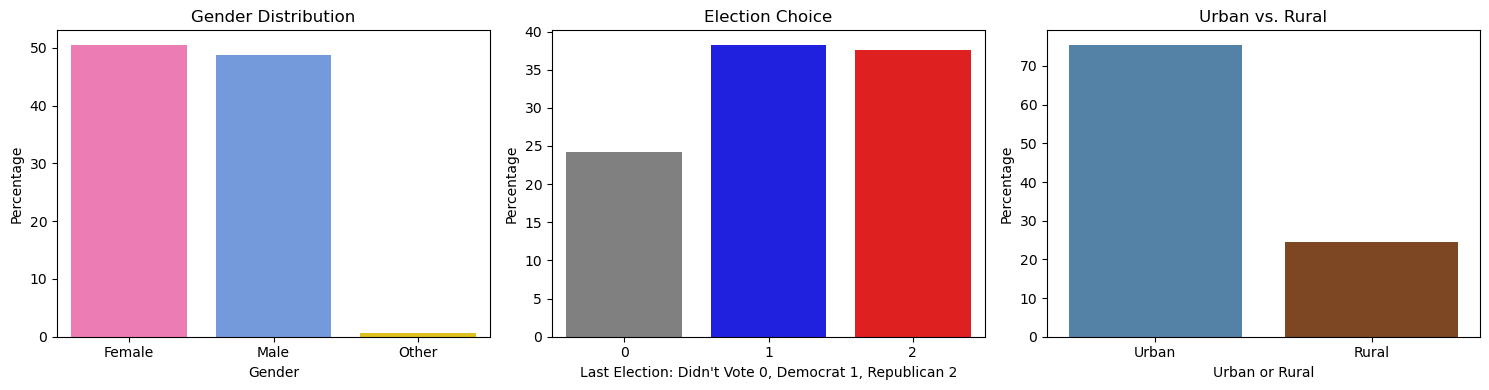

In [54]:
# 🎯 Choose a cluster to explore
selected_cluster = 1  # Change this to 0, 1, 2, 3, or 4

# Filter data for the selected cluster
cluster_data = df[df["Cluster"] == selected_cluster]
cluster_size = cluster_data.shape[0]

# 📊 Compute summary statistics
cluster_summary = cluster_data[composite_scores + ["Age"]].describe().T[["mean", "std"]]

# 📌 Demographic breakdowns
gender_counts = cluster_data["Gender"].value_counts(normalize=True) * 100
election_counts = cluster_data["Last Election: Didn't Vote 0, Democrat 1, Republican 2"].value_counts(normalize=True) * 100
urban_rural_counts = cluster_data["Urban or Rural"].value_counts(normalize=True) * 100

# 🎨 Style the table
styled_summary = cluster_summary.style.background_gradient(cmap="Blues").format({"mean": "{:.2f}", "std": "{:.2f}"})

# 📊 Plot demographics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Gender Bar Plot with Proper Color Assignments
gender_palette = {"Male": "#6495ED", "Female": "#FF69B4", "Other": "#FFD700"}  # Blue, Pink, Yellow
sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[0], palette=[gender_palette[g] for g in gender_counts.index])
axes[0].set_title("Gender Distribution")
axes[0].set_ylabel("Percentage")

# Election Choice Bar Plot
sns.barplot(x=election_counts.index, y=election_counts.values, ax=axes[1], palette=["gray", "blue", "red"])
axes[1].set_title("Election Choice")
axes[1].set_ylabel("Percentage")

# Urban vs. Rural Bar Plot
sns.barplot(x=urban_rural_counts.index, y=urban_rural_counts.values, ax=axes[2], palette=["#4682B4", "#8B4513"])  # Steel Blue & Saddle Brown
axes[2].set_title("Urban vs. Rural")
axes[2].set_ylabel("Percentage")

plt.tight_layout()

# 🔥 Display results
print(f"\n🔹 **Cluster {selected_cluster}: {cluster_size} Respondents**\n")
display(styled_summary)
plt.show()



## Conclusions
Initially, this notebook aimed to calculate similarity scores between respondents and visualize them in a network. However, due to the large dataset size, generating 1,000+ nodes with millions of edges quickly became computationally infeasible. Beyond technical limitations, the resulting networks would have been too complex to interpret meaningfully.

Instead, this notebook provides an interactive framework for exploring composite scores in a more focused, intuitive way. Users can:

✅ Select individual or multiple composite scores to analyze respondent similarities.
✅ Interactively explore respondents’ data based on K-Means clustering.
✅ Generate & compare clusters based on shared characteristics.

## Next Steps & Features
**Refining Austria Data for Compatibility**
    Formatting Austria’s survey responses to match this framework is part of a longer-term goal. It will add a new level of comparativity and interactivty

**Re-intergratring and Improving Similarity Score Efficiency**
    Storing precomputed similarity scores may allow for faster comparisons in future work, but this too needs a plan.
    
   
**Testing different clustering methods**
    For more efficient network interaction or visual;ization tools, possibly easier on the computer gererating the network.

## Disclaimer on ChatGPT
ChatGPT was a partner on this project, especially in troubleshooting code, refinining procedures when netwoork visualizations were not cooperating, and in improving the readability of code blocks and markdown tabs. I worked to refine the code from ChatGPT, catching errors, and suggesting ways to make interface elements better. I take responsability for the final products of the project, and feel inspired by the skills I have learned in this class!